In [21]:
import pandas as pd
df = pd.read_csv('spange_melt.csv')

dictionary = {
}
solvent_types = df['solvent'].to_list()
SMILES = df['SMILES'].to_list()

for i in range(len(SMILES)):
    dictionary[SMILES[i]] = solvent_types[i]

print(dictionary)

{'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid', 'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester', 'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether', 'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone', 'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol', 'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol', 'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol', 'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol'}


In [42]:
from catechol.data.loader import (
    generate_leave_one_out_splits,
    load_single_solvent_data,
    replace_repeated_measurements_with_average,
)

single_solvent = load_single_solvent_data()
X = single_solvent[[
    "Residence Time", "Temperature", "Reaction SMILES",
    "SOLVENT SMILES", "SOLVENT NAME", "SOLVENT Ratio"
]]
Y = single_solvent[["SM", "Product 2", "Product 3"]]

data_df = pd.concat([X, Y], axis=1)
data_df['Product 2 + product 3'] = data_df['Product 2'] + data_df['Product 3']
min_SM = data_df[['SOLVENT SMILES', 'SM']]

# 2. Create the new DataFrame containing only the desired columns
# The list of columns is ['SOLVENT SMILES', 'Product 2 + product 3']
new_df = data_df[['SOLVENT SMILES', 'Product 2 + product 3']]

# Group the new_df by 'SOLVENT SMILES'
# and then find the maximum value in the 'Product 2 + product 3' column for each group.
# Finally, convert the resulting Series to a dictionary.
max_yield_dict = new_df.groupby('SOLVENT SMILES')['Product 2 + product 3'].max().to_dict()
min_SM_dict = min_SM.groupby('SOLVENT SMILES')['SM'].min().to_dict()
print(max_yield_dict)
print(min_SM_dict)

ratio_dict = {
}

for key, value in max_yield_dict.items():
    ratio = value/(value + min_SM_dict[key])
    ratio_dict[key] = ratio

print(ratio_dict)



{'C(C(F)(F)F)(C(F)(F)F)O': 0.8009880342431233, 'C1CCCCC1': 0.5224429181148627, 'C1CCOC1': 0.4623411434251476, 'CC#N': 0.6053347263323902, 'CC#N.CC(=O)O': 0.0641299963479116, 'CC(C)(C)O': 0.19058036798978462, 'CC(C)(C)OC': 0.1037727520649682, 'CC(O)C': 0.8544404745941441, 'CCC(=O)C': 0.11687113616050951, 'CCCCCCCCCCO': 0.8032877518592167, 'CCOC(=O)C(C)O': 0.3138329262265084, 'CCOCC': 0.40978743271984097, 'CN(C)C(C)=O': 0.5087426077797614, 'CO': 0.6529608240220712, 'COC(=O)OC': 0.1085030401503261, 'O.CC#N': 0.8894482081597888, 'O.OCC(F)(F)F': 0.6947144543369447, 'O1C(C)CCC1': 0.5557530552270729, 'O=C(OC)CC': 0.0578773585593338, 'O=C(OCC)C': 0.10130152662696029, 'OCC': 0.735470792873231, 'OCC(F)(F)F': 0.4148861908297234, 'OCCO': 0.997399548022839, '[C@H]12CCC([C@H](OC1)O2)=O': 0.41239213993039037}
{'C(C(F)(F)F)(C(F)(F)F)O': 0.0, 'C1CCCCC1': 0.2292552231874948, 'C1CCOC1': 0.1870473754706084, 'CC#N': 0.1320261327971227, 'CC#N.CC(=O)O': 0.0, 'CC(C)(C)O': 0.6525019682678372, 'CC(C)(C)OC': 0.8

26
['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


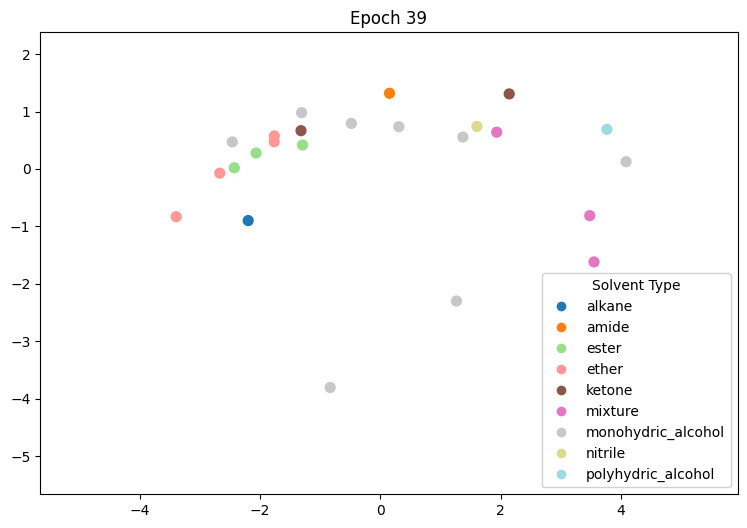

In [23]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by solvent type (from smiles_to_type mapping) and includes a legend.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type.
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mapping
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/fingerprints_batch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Assign a fixed color per solvent type
    solvent_types = sorted(plot_df["type"].unique())
    cmap = plt.get_cmap("tab20", len(solvent_types))
    color_map = {stype: cmap(i) for i, stype in enumerate(solvent_types)}

     # Step 5: Set up animation
    fig, ax = plt.subplots(figsize=(9, 6))  # wider figure so legend fits
    scat = ax.scatter([], [], s=50)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add legend for solvent types - positioned in bottom right corner
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[stype], markersize=8, label=stype)
        for stype in solvent_types
    ]
    ax.legend(
        handles=legend_elements,
        title="Solvent Type",
        loc='lower right',
        framealpha=0.9  # slight transparency so you can see points behind
    )

    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        colors = [color_map[stype] for stype in df_e["type"]]
        scat.set_offsets(coords)
        scat.set_color(colors)
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                        init_func=init, blit=True, repeat=True, interval=500)

    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()



# Example usage:
smiles_to_type = {
    'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid',
    'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester',
    'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether',
    'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone',
    'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol',
    'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol',
    'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol',
    'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol', 'CC#N.CC(=O)O': 'mixture',
    'O.CC#N': 'mixture',
    'O.OCC(F)(F)F': 'mixture'
}
print(len(list(smiles_to_type.keys())))
process_embeddings("solvent_fps", smiles_to_type, save_path="pca_by_type_with_legend.gif")

['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


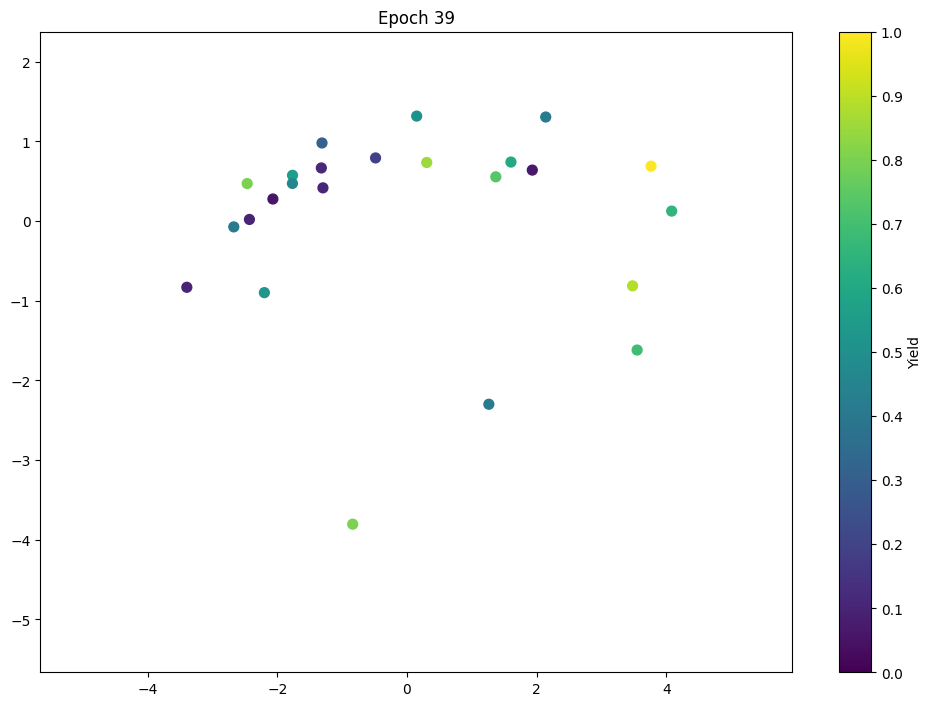

In [24]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, yield_lookup, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by yield value (from yield_lookup mapping) using a heatmap.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type (used for
                                canonicalization, but not for coloring).
        yield_lookup (dict): Mapping from SMILES to a yield value (0-1).
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mappings
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }
    yield_lookup_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): y
        for s, y in yield_lookup.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/fingerprints_batch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            yield_val = yield_lookup_canon.get(sid_canon, 0.0) # Get yield value, default to 0.0 if not found
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "yield": yield_val,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Set up animation
    fig, ax = plt.subplots(figsize=(10, 7)) # Adjust figure size for colorbar
    
    # Use a colormap for coloring points by yield
    scat = ax.scatter([], [], s=50, c=[], cmap='viridis', vmin=0, vmax=1)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add a colorbar to represent the yield scale (0 to 1)
    cbar = fig.colorbar(scat, ax=ax, label="Yield")
    cbar.set_ticks(np.linspace(0, 1, 11))

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array([])
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        yield_values = df_e["yield"].values
        scat.set_offsets(coords)
        scat.set_array(yield_values) # Set color based on yield values
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                         init_func=init, blit=True, repeat=True, interval=500)
    plt.tight_layout()
    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()

# Example usage with the provided dictionaries
process_embeddings(
    "solvent_fps",
    smiles_to_type,
    max_yield_dict,
    save_path="pca_by_yield_heatmap.gif"
)

26
['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


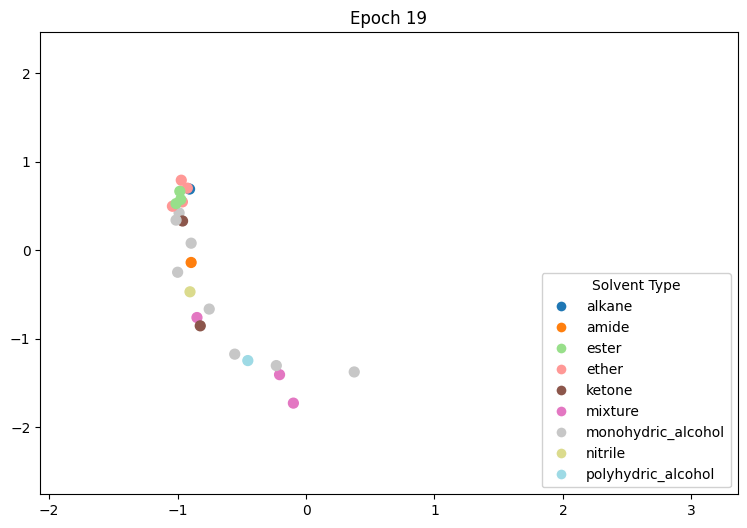

In [25]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by solvent type (from smiles_to_type mapping) and includes a legend.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type.
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mapping
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/projection_embeddings_epoch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Assign a fixed color per solvent type
    solvent_types = sorted(plot_df["type"].unique())
    cmap = plt.get_cmap("tab20", len(solvent_types))
    color_map = {stype: cmap(i) for i, stype in enumerate(solvent_types)}

     # Step 5: Set up animation
    fig, ax = plt.subplots(figsize=(9, 6))  # wider figure so legend fits
    scat = ax.scatter([], [], s=50)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add legend for solvent types - positioned in bottom right corner
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[stype], markersize=8, label=stype)
        for stype in solvent_types
    ]
    ax.legend(
        handles=legend_elements,
        title="Solvent Type",
        loc='lower right',
        framealpha=0.9  # slight transparency so you can see points behind
    )

    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        colors = [color_map[stype] for stype in df_e["type"]]
        scat.set_offsets(coords)
        scat.set_color(colors)
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                        init_func=init, blit=True, repeat=True, interval=500)

    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()



# Example usage:
smiles_to_type = {
    'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid',
    'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester',
    'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether',
    'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone',
    'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol',
    'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol',
    'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol',
    'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol', 'CC#N.CC(=O)O': 'mixture',
    'O.CC#N': 'mixture',
    'O.OCC(F)(F)F': 'mixture'
}
print(len(list(smiles_to_type.keys())))
process_embeddings("solvent_fps_proj", smiles_to_type, save_path="pca_by_type_with_legend_proj.gif")

['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


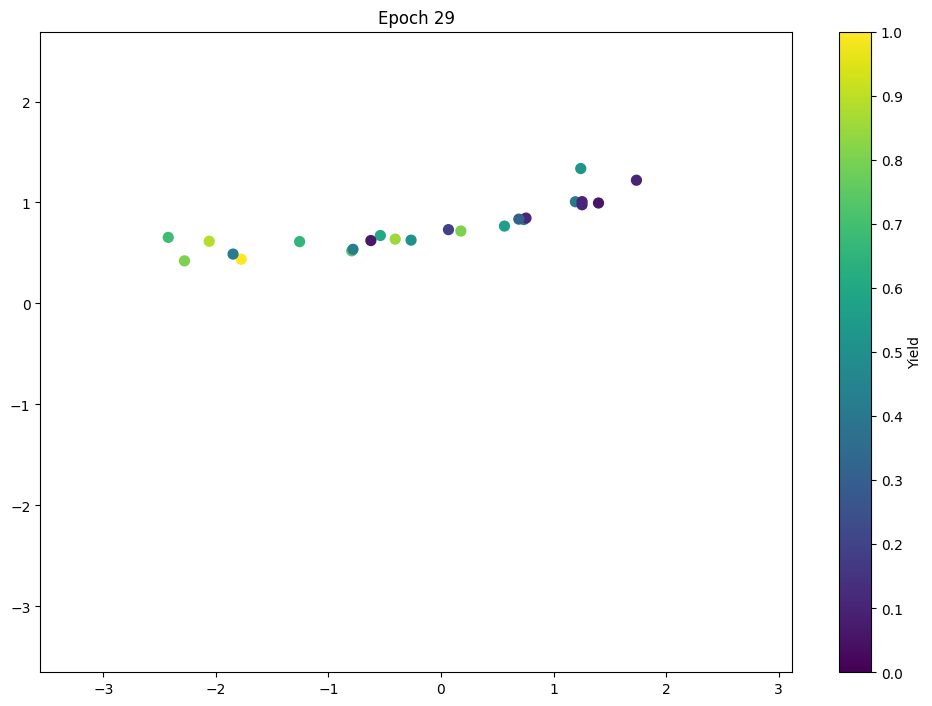

In [28]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, yield_lookup, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by yield value (from yield_lookup mapping) using a heatmap.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type (used for
                                canonicalization, but not for coloring).
        yield_lookup (dict): Mapping from SMILES to a yield value (0-1).
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mappings
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }
    yield_lookup_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): y
        for s, y in yield_lookup.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/projection_embeddings_epoch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            yield_val = yield_lookup_canon.get(sid_canon, 0.0) # Get yield value, default to 0.0 if not found
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "yield": yield_val,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Set up animation
    fig, ax = plt.subplots(figsize=(10, 7)) # Adjust figure size for colorbar
    
    # Use a colormap for coloring points by yield
    scat = ax.scatter([], [], s=50, c=[], cmap='viridis', vmin=0, vmax=1)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add a colorbar to represent the yield scale (0 to 1)
    cbar = fig.colorbar(scat, ax=ax, label="Yield")
    cbar.set_ticks(np.linspace(0, 1, 11))

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array([])
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        yield_values = df_e["yield"].values
        scat.set_offsets(coords)
        scat.set_array(yield_values) # Set color based on yield values
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                         init_func=init, blit=True, repeat=True, interval=500)
    plt.tight_layout()
    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()

# Example usage with the provided dictionaries
process_embeddings(
    "solvent_fps_proj",
    smiles_to_type,
    max_yield_dict,
    save_path="pca_by_yield_heatmap.gif"
)

['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


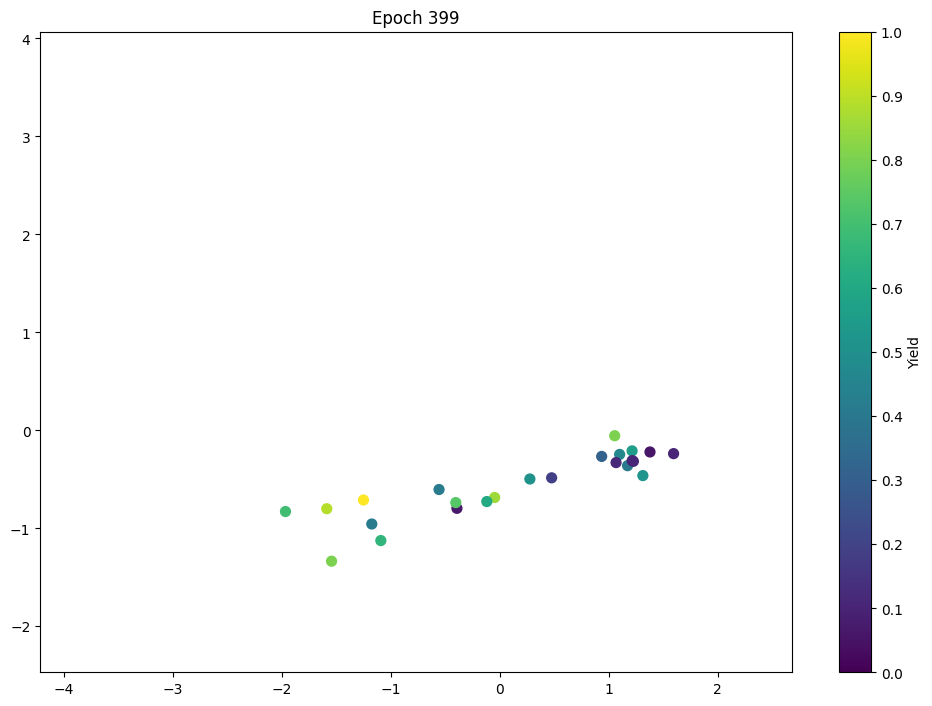

In [36]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, yield_lookup, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by yield value (from yield_lookup mapping) using a heatmap.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type (used for
                                canonicalization, but not for coloring).
        yield_lookup (dict): Mapping from SMILES to a yield value (0-1).
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mappings
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }
    yield_lookup_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): y
        for s, y in yield_lookup.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/projection_embeddings_batch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            yield_val = yield_lookup_canon.get(sid_canon, 0.0) # Get yield value, default to 0.0 if not found
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "yield": yield_val,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Set up animation
    fig, ax = plt.subplots(figsize=(10, 7)) # Adjust figure size for colorbar
    
    # Use a colormap for coloring points by yield
    scat = ax.scatter([], [], s=50, c=[], cmap='viridis', vmin=0, vmax=1)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add a colorbar to represent the yield scale (0 to 1)
    cbar = fig.colorbar(scat, ax=ax, label="Yield")
    cbar.set_ticks(np.linspace(0, 1, 11))

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array([])
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        yield_values = df_e["yield"].values
        scat.set_offsets(coords)
        scat.set_array(yield_values) # Set color based on yield values
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                         init_func=init, blit=True, repeat=True, interval=100)
    plt.tight_layout()
    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()

# Example usage with the provided dictionaries
process_embeddings(
    "solvent_fps_proj_batch",
    smiles_to_type,
    max_yield_dict,
    save_path="pca_by_yield_heatmap_batch.gif"
)

26
['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


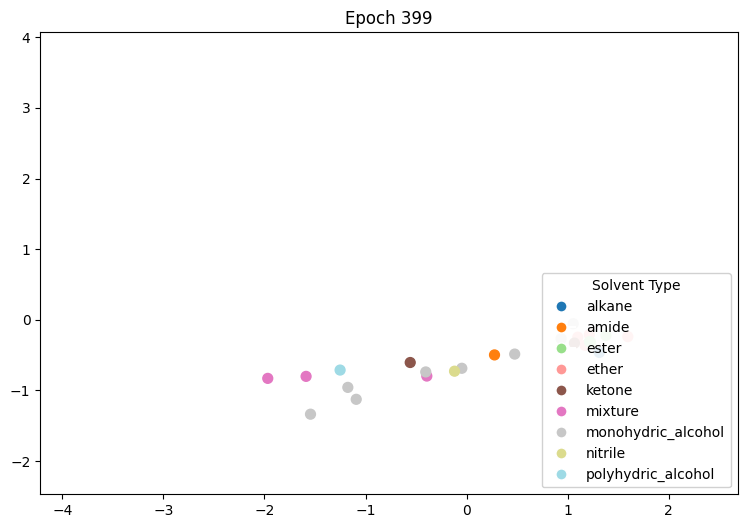

In [37]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by solvent type (from smiles_to_type mapping) and includes a legend.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type.
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mapping
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/projection_embeddings_batch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs combined
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Assign a fixed color per solvent type
    solvent_types = sorted(plot_df["type"].unique())
    cmap = plt.get_cmap("tab20", len(solvent_types))
    color_map = {stype: cmap(i) for i, stype in enumerate(solvent_types)}

     # Step 5: Set up animation
    fig, ax = plt.subplots(figsize=(9, 6))  # wider figure so legend fits
    scat = ax.scatter([], [], s=50)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add legend for solvent types - positioned in bottom right corner
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[stype], markersize=8, label=stype)
        for stype in solvent_types
    ]
    ax.legend(
        handles=legend_elements,
        title="Solvent Type",
        loc='lower right',
        framealpha=0.9  # slight transparency so you can see points behind
    )

    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        colors = [color_map[stype] for stype in df_e["type"]]
        scat.set_offsets(coords)
        scat.set_color(colors)
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                        init_func=init, blit=True, repeat=True, interval=100)

    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()



# Example usage:
smiles_to_type = {
    'C1CCCCC1': 'alkane', 'CC(=O)N(C)C': 'amide', 'CC(=O)O': 'carboxylic_acid',
    'CCC(=O)OC': 'ester', 'CCOC(C)=O': 'ester', 'COC(=O)OC': 'ester',
    'C1CCOC1': 'ether', 'CC1CCCO1': 'ether', 'CCOCC': 'ether', 'COC(C)(C)C': 'ether',
    'CCC(C)=O': 'ketone', 'O=C1CC[C@H]2CO[C@@H]1O2': 'ketone',
    'CC(C)(C)O': 'monohydric_alcohol', 'CC(C)O': 'monohydric_alcohol', 'CCCCCCCCCCO': 'monohydric_alcohol',
    'CCO': 'monohydric_alcohol', 'CCOC(=O)C(C)O': 'monohydric_alcohol', 'CO': 'monohydric_alcohol',
    'OC(C(F)(F)F)C(F)(F)F': 'monohydric_alcohol', 'OCC(F)(F)F': 'monohydric_alcohol',
    'CC#N': 'nitrile', 'O': 'polyhydric_alcohol', 'OCCO': 'polyhydric_alcohol', 'CC#N.CC(=O)O': 'mixture',
    'O.CC#N': 'mixture',
    'O.OCC(F)(F)F': 'mixture'
}
print(len(list(smiles_to_type.keys())))
process_embeddings("solvent_fps_proj_batch", smiles_to_type, save_path="pca_by_type_with_legend_proj_batch.gif")



['CO', 'OCCO', 'C(C(F)(F)F)(C(F)(F)F)O', 'O1C(C)CCC1', 'C1CCCCC1', 'CC(O)C', 'O.CC#N', 'CC#N', 'CC#N.CC(=O)O', 'CCOCC', 'OCC(F)(F)F', 'O.OCC(F)(F)F', 'CN(C)C(C)=O', 'CCCCCCCCCCO', 'OCC', 'C1CCOC1', '[C@H]12CCC([C@H](OC1)O2)=O', 'O=C(OCC)C', 'CC(C)(C)OC', 'CCC(=O)C', 'CC(C)(C)O', 'COC(=O)OC', 'O=C(OC)CC', 'CCOC(=O)C(C)O'] 24


MovieWriter ffmpeg unavailable; using Pillow instead.


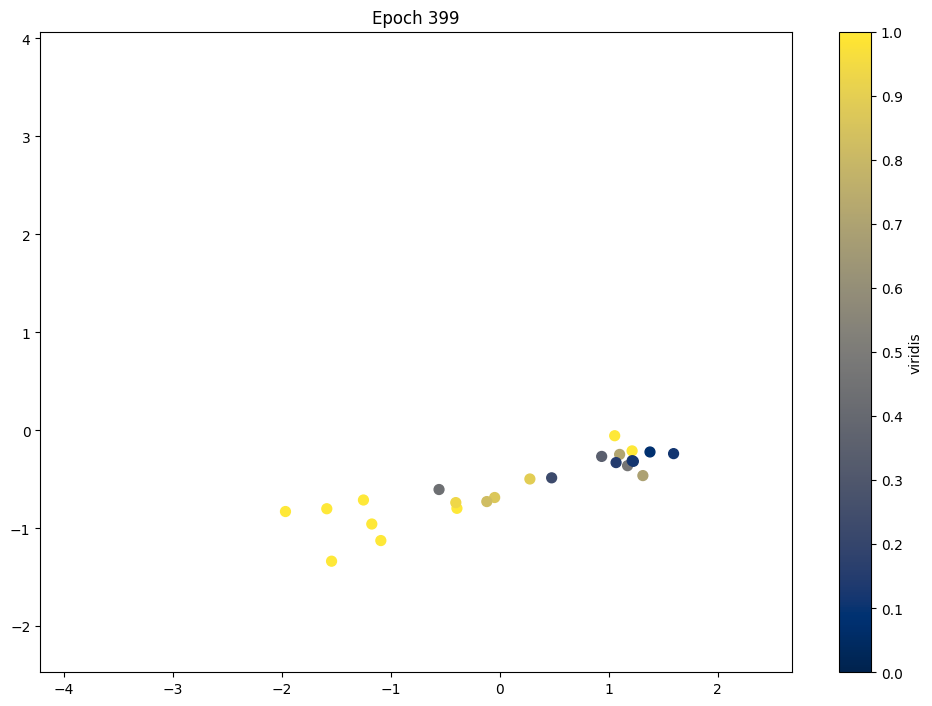

In [ ]:
import json
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

def canonicalize_smiles_with_enhanced_stereo(smiles):
    """
    Canonicalize a SMILES string, preserving enhanced stereochemistry for mixtures.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return smiles  # return unchanged if invalid
    # Preserve enhanced stereo (important for mixtures)
    return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

def process_embeddings(input_dir, smiles_to_type, yield_lookup, save_path=None):
    """
    Loads, processes, and animates PCA of embeddings from a specified directory.
    Colors points by yield value (from yield_lookup mapping) using a heatmap.

    Args:
        input_dir (str): Directory containing the JSON embedding files.
        smiles_to_type (dict): Mapping from SMILES to solvent type (used for
                                canonicalization, but not for coloring).
        yield_lookup (dict): Mapping from SMILES to a yield value (0-1).
        save_path (str, optional): Path to save the animation.
    """
    # Step 0: Canonicalize SMILES in mappings
    smiles_to_type_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): t
        for s, t in smiles_to_type.items()
    }
    yield_lookup_canon = {
        canonicalize_smiles_with_enhanced_stereo(s): y
        for s, y in yield_lookup.items()
    }

    # Step 1: Load embeddings
    all_embeddings = []
    epochs = []
    solvent_ids = None

    files = sorted(
        glob.glob(f"{input_dir}/projection_embeddings_batch_*.json"),
        key=lambda f: int(f.split("_")[-1].split(".")[0])
    )

    epoch_data = {}
    count = 0
    for f in files:
        epoch = int(f.split("_")[-1].split(".")[0])
        with open(f) as fp:
            data = json.load(fp)
        if solvent_ids is None:
            solvent_ids = list(data.keys())
            if count == 0:
                print(solvent_ids, len(solvent_ids))
                count += 1
        embeddings = np.array([data[s] for s in solvent_ids])
        all_embeddings.append(embeddings)
        epochs.append(epoch)
        epoch_data[epoch] = embeddings

    # Step 2: PCA on all epochs 
    X_all = np.vstack(all_embeddings)
    pca = PCA(n_components=2)
    pca.fit(X_all)

    # Step 3: Transform and store
    plot_df = []
    for epoch in epochs:
        coords = pca.transform(epoch_data[epoch])
        for sid, (pc1, pc2) in zip(solvent_ids, coords):
            sid_canon = canonicalize_smiles_with_enhanced_stereo(sid)
            solvent_type = smiles_to_type_canon.get(sid_canon, "unknown")
            yield_val = yield_lookup_canon.get(sid_canon, 0.0) # Get yield value, default to 0.0 if not found
            plot_df.append({
                "epoch": epoch,
                "solvent": sid_canon,
                "type": solvent_type,
                "yield": yield_val,
                "PC1": pc1,
                "PC2": pc2
            })
    plot_df = pd.DataFrame(plot_df)

    # Step 4: Set up animation
    fig, ax = plt.subplots(figsize=(10, 7)) # Adjust figure size for colorbar
    
    # Use a colormap for coloring points by yield
    scat = ax.scatter([], [], s=50, c=[], cmap='cividis', vmin=0, vmax=1)

    ax.set_xlim(plot_df["PC1"].min() - 1, plot_df["PC1"].max() + 1)
    ax.set_ylim(plot_df["PC2"].min() - 1, plot_df["PC2"].max() + 1)
    title = ax.set_title("")

    # Add a colorbar to represent the yield scale (0 to 1)
    cbar = fig.colorbar(scat, ax=ax, label="viridis")
    cbar.set_ticks(np.linspace(0, 1, 11))

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array([])
        return scat, title

    def update(frame_idx):
        epoch = epochs[frame_idx]
        df_e = plot_df[plot_df.epoch == epoch]
        coords = df_e[["PC1", "PC2"]].values
        yield_values = df_e["yield"].values
        scat.set_offsets(coords)
        scat.set_array(yield_values) # Set color based on yield values
        title.set_text(f"Epoch {epoch}")
        return scat, title

    ani = FuncAnimation(fig, update, frames=len(epochs),
                         init_func=init, blit=True, repeat=True, interval=100)
    plt.tight_layout()
    if save_path:
        ani.save(save_path, dpi=150)
    else:
        plt.show()

# Example usage with the provided dictionaries
process_embeddings(
    "solvent_fps_proj_batch",
    smiles_to_type,
    ratio_dict,
    save_path="pca_by_SM_heatmap_batch.gif"
)